<a href="https://colab.research.google.com/github/fabriciocarraro/PyTorch-Bike-Sharing-Regression/blob/main/PyTorch_Bike_Sharing_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
args = {
    'batch_size': 20,
    'num_workers': 4,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [3]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip

--2024-10-23 18:25:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase     [    <=>             ] 273.43K   231KB/s    in 1.2s    

2024-10-23 18:25:12 (231 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [4]:
!ls

Bike-Sharing-Dataset.zip  day.csv  hour.csv  Readme.txt  sample_data


In [5]:
df = pd.read_csv('hour.csv')
print(df.shape)
df.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
torch.manual_seed(1)
indices = torch.randperm(df.shape[0])

train_size = int(df.shape[0] * 0.8)

df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

print(df_train.shape, df_test.shape)

(13903, 17) (3476, 17)


In [7]:
df_train.to_csv('bike_train.csv', index=False)
df_test.to_csv('bike_test.csv', index=False)

In [8]:
class BikeSharing(Dataset):
  def __init__(self, csv_path):
    self.df = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):
    sample = self.df[idx][2:14]
    label = self.df[idx][-1:]

    # Convert to Tensors
    sample = torch.from_numpy(sample.astype(np.float32))
    label = torch.from_numpy(label.astype(np.float32))

    return sample, label

  def __len__(self):
    return self.df.shape[0]

In [9]:
train_set = BikeSharing('bike_train.csv')
test_set = BikeSharing('bike_test.csv')

In [10]:
sample, label = train_set[0]
print(sample)
print(label)

tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])
tensor([373.])


In [11]:
train_loader = DataLoader(train_set, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_workers'])
test_loader = DataLoader(test_set, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_workers'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
class BikeRegression(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(BikeRegression, self).__init__()

    self.features = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    self.output = nn.Linear(hidden_size, output_size)

  def forward(self, X):
    feature = self.features(X)
    output = self.output(feature)

    return output

In [13]:
input_size = len(train_set[0][0]) # number of features in the train set
hidden_size = 128
output_size = 1 # regression to one value

net = BikeRegression(input_size, hidden_size, output_size).to(args['device'])

In [14]:
criterion = nn.L1Loss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [15]:
def train(train_loader, net, epoch):
  net.train()

  start = time.time()

  epoch_loss = []

  for batch in train_loader:
    sample, label = batch

    sample = sample.to(args['device']) # cast to GPU
    label = label.to(args['device']) # cast to GPU

    # Forward
    pred = net(sample)
    loss = criterion(pred, label)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [16]:
def test(test_loader, net, epoch):
  net.eval()
  with torch.no_grad():

    start = time.time()

    epoch_loss = []

    for batch in test_loader:
      sample, label = batch

      sample = sample.to(args['device']) # cast to GPU
      label = label.to(args['device']) # cast to GPU

      # Forward
      pred = net(sample)
      loss = criterion(pred, label)
      epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)

    end = time.time()
    print('********** Validate **********')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

    return epoch_loss.mean()

In [17]:
train_losses, test_losses = [], []

for epoch in range(args['num_epochs']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(test(test_loader, net, epoch))

  print('-----------------------------------------')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#################### Train ####################
Epoch 0, Loss: 149.5431 +/- 40.7663, Time: 4.52
********** Validate **********
Epoch 0, Loss: 132.0381 +/- 21.7941, Time: 0.62

-----------------------------------------
#################### Train ####################
Epoch 1, Loss: 125.1214 +/- 32.3439, Time: 2.23
********** Validate **********
Epoch 1, Loss: 114.7287 +/- 25.3082, Time: 0.46

-----------------------------------------
#################### Train ####################
Epoch 2, Loss: 122.4004 +/- 29.8473, Time: 2.23
********** Validate **********
Epoch 2, Loss: 122.2157 +/- 30.7584, Time: 0.45

-----------------------------------------
#################### Train ####################
Epoch 3, Loss: 117.2712 +/- 27.4822, Time: 2.26
********** Validate **********
Epoch 3, Loss: 114.4811 +/- 26.8730, Time: 0.52

-----------------------------------------
#################### Train ####################
Epoch 4, Loss: 115.1293 +/- 29.1694, Time: 2.59
********** Validate **********
E

In [18]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,352.0,263.693085
1,156.0,43.013348
2,12.0,12.995083
3,2.0,60.092197
4,391.0,175.991302
5,391.0,276.785126
6,84.0,174.927765
7,487.0,540.106140
8,176.0,169.609879
9,157.0,32.455097


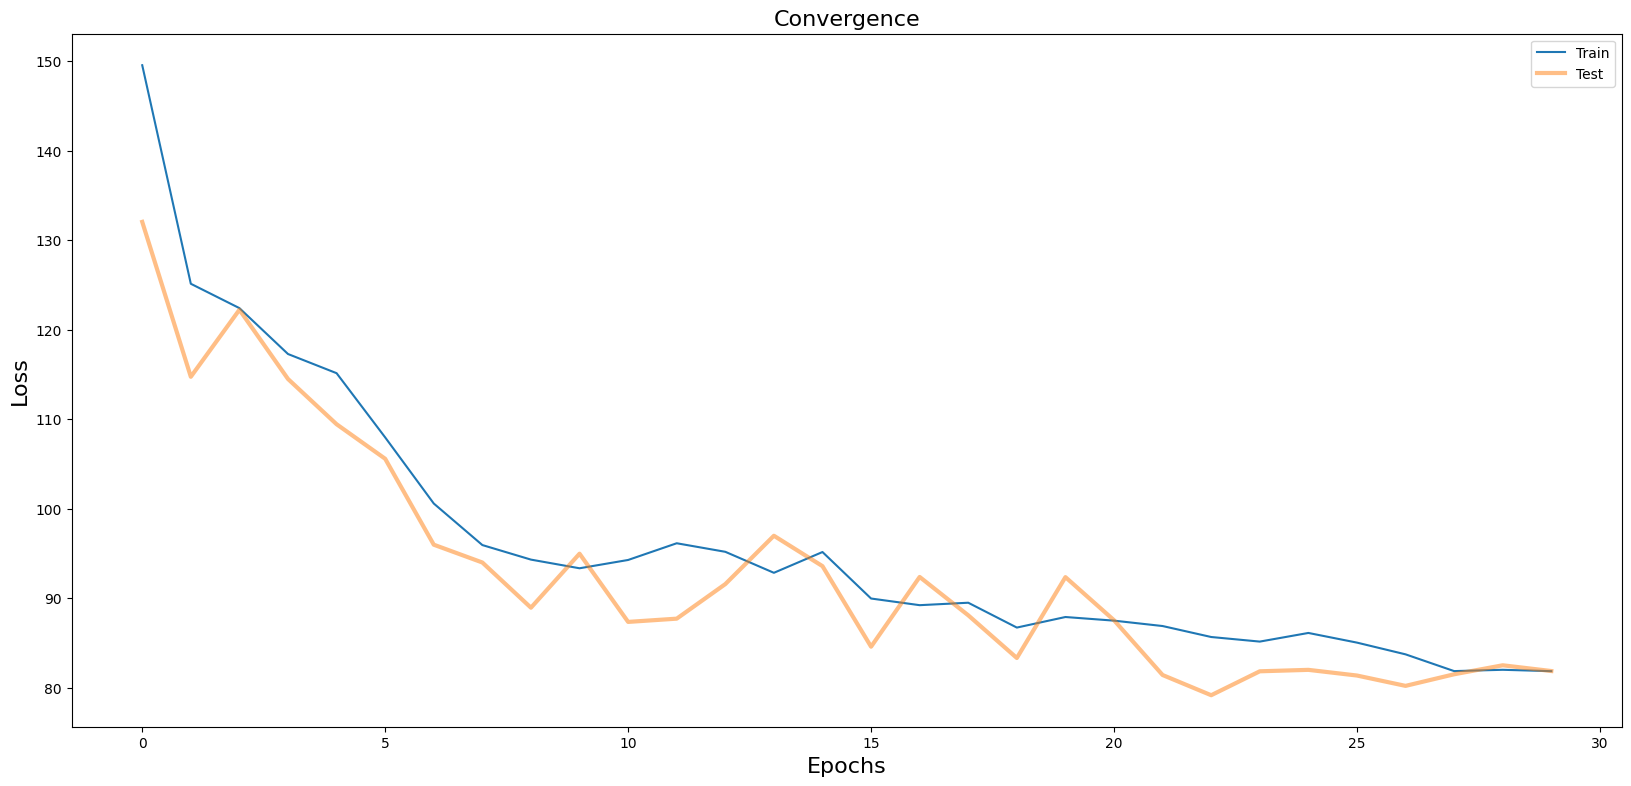

In [20]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()